問１．横軸に現在の資産、縦軸に貯蓄率を取ったグラフを書け

In [86]:
# Solve No.1

import numpy as np
from scipy.stats import norm

def tauchen(n, mu, rho, sigma):

    # n: number of grid points
    # mu: mean of the AR(1) process
    # rho: AR(1) coeffient
    # sigma: standard deviatin of the error term

    m = 1 / np.sqrt(1 - rho**2)

    # compute the state space
    state_space = np.linspace(mu - m*sigma, mu + m*sigma, n)

    # compute the distance between grid points
    d = (state_space[n-1] - state_space[0]) / (n-1)

    # compute the transition probabilities
    transition_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if j==0:
                transition_matrix[i, 0] = norm.cdf((state_space[0] - rho*state_space[i] + d/2)/sigma)
            elif j==n-1:
                transition_matrix[i, n-1] = 1.0 - norm.cdf((state_space[n-1] - rho*state_space[i] - d/2)/sigma)
            else:
                transition_matrix[i, j] = norm.cdf((state_space[j] - rho*state_space[i] + d/2)/sigma) - norm.cdf((state_space[j] - rho*state_space[i] - d/2)/sigma)

    return transition_matrix, state_space


In [87]:
# function to compile parameters into one thing "param"
def setPar(
    sigma = 1.5, # risk aversion
    beta = 0.98, # subject discount factor
    rho = 0.6, # labor productivity persistence
    sigma_eps = 0.6, # labor productivity std
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NA = 401, # number of grids of a
    NH = 2, # number of grids of h
    mu_h = -0.7, # mean of log h
    tau = 0.3, # capital income tax *use in question 2
    T = 1, # subsidy *use in question 3
    ):

    # # create a grid of asset holdings
    # a = np.linspace(a_l, a_u, NA)

    # making grids for ln h and solving for income transition probability using Tauchen's method
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    # create dictionary with parameters
    param = {}
    param['sigma'] = sigma
    param['beta'] = beta
    param['pi'] = pi
    param['h'] = h
    param['NA'] = NA
    param['NH'] = NH
    param['a_l'] = a_l
    param['a_u'] = a_u
    param['tau'] = tau
    param['T'] = T
    


    return param

In [88]:
def solve_household(param):
    # opening the box of param
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))

    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)

    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # iterate on bellman's equation and get the decision rules and the value function
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol: # loop until value function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c


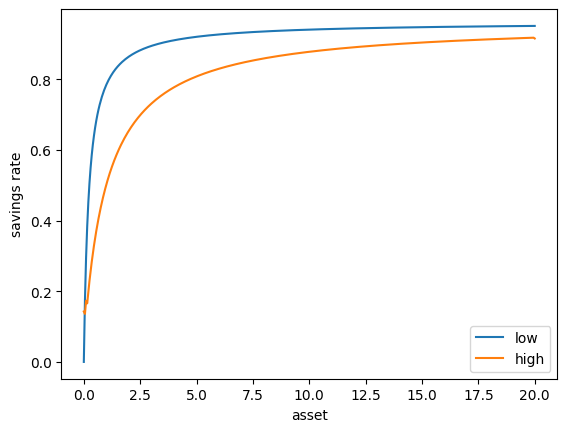

Saving rates for low h:
[0.         0.17447726 0.29535964 0.38405379 0.45190562 0.50548932
 0.54887726 0.58472665 0.61484517 0.64050531 0.66262879 0.68189965
 0.6988362  0.71383836 0.72721962 0.73922922 0.75006777 0.7598986
 0.76885601 0.77705144 0.78457815 0.79151479 0.79792812 0.80387522
 0.80940513 0.81456028 0.8193775  0.82388898 0.82812292 0.83210417
 0.83585469 0.83939399 0.84273941 0.84590646 0.84890903 0.85175962
 0.85446947 0.85704877 0.85950671 0.86185168 0.86409128 0.86623246
 0.86828157 0.87024442 0.87212634 0.87393225 0.87566665 0.87733371
 0.87893727 0.8804809  0.8819679  0.88340132 0.88478401 0.88611861
 0.8874076  0.88865327 0.88985776 0.8910231  0.89215114 0.89324367
 0.89430232 0.89532866 0.89632413 0.89729011 0.89822789 0.89913869
 0.90002366 0.90088387 0.90172036 0.90253409 0.90332598 0.90409689
 0.90484766 0.90557905 0.90629181 0.90698664 0.90766421 0.90832515
 0.90897008 0.90959955 0.91021414 0.91081434 0.91140068 0.91197361
 0.91253359 0.91308107 0.91361644 0.914

In [89]:
import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage

param = setPar() # parameters
decisions = solve_household(param) # HH problem
aplus = decisions[0]
c = decisions[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# Saving rate for low h
low_saving_rate = aplus[:, 0]/(c[:, 0] + aplus[:, 0])
plt.plot(a, low_saving_rate, label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# Saving rate for high h
high_saving_rate = aplus[:, 1]/(c[:, 1] + aplus[:, 1])
plt.plot(a, high_saving_rate, label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()
plt.show()

# Print saving rates
print("Saving rates for low h:")
print(low_saving_rate)

print("Saving rates for high h:")
print(high_saving_rate)



問２．資本所得税(τ＝0.3)を導入

In [90]:
# Solve No.2

def solve_household(param):
    # opening the box of param
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']
    tau = param['tau']


    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))

    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)

    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 +(1.0 - tau) * r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # iterate on bellman's equation and get the decision rules and the value function
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol: # loop until value function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + (1.0 - tau) * r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c


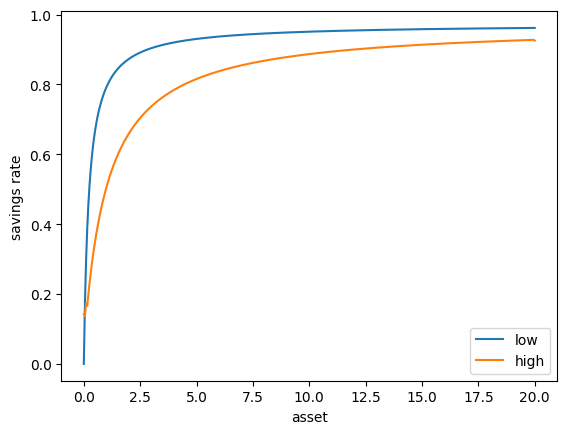

Saving rates for low h:
[0.         0.17484334 0.29641022 0.38583195 0.45436961 0.50857427
 0.55251642 0.58885851 0.61941531 0.64546641 0.66793995 0.68752553
 0.70474623 0.72000597 0.73362167 0.74584543 0.75688031 0.76689172
 0.77601574 0.78436534 0.79203511 0.79910483 0.80564226 0.81170533
 0.81734388 0.82260097 0.82751406 0.83211583 0.83643497 0.84049674
 0.84432348 0.84793501 0.85134899 0.85458121 0.85764579 0.86055545
 0.86332166 0.86595475 0.86846412 0.87085829 0.873145   0.87533134
 0.87742378 0.87942823 0.88135013 0.88319447 0.88496587 0.88666856
 0.88830646 0.88988321 0.89140216 0.89286643 0.89427893 0.89564236
 0.89695922 0.89823187 0.89946249 0.90065313 0.90180571 0.90292202
 0.90400375 0.90505249 0.90606971 0.90705683 0.90801515 0.90894591
 0.9098503  0.91072941 0.91158429 0.91241593 0.91322526 0.91401317
 0.9147805  0.91552804 0.91625656 0.91696676 0.91765933 0.91833491
 0.91899413 0.91963758 0.9202658  0.92087935 0.92147871 0.92206439
 0.92263684 0.9231965  0.92374381 0.92

In [91]:
import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage

param = setPar() # parameters
decisions = solve_household(param) # HH problem
aplus = decisions[0]
c = decisions[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# Saving rate for low h
low_saving_rate = aplus[:, 0]/(c[:, 0] + aplus[:, 0])
plt.plot(a, low_saving_rate, label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# Saving rate for high h
high_saving_rate = aplus[:, 1]/(c[:, 1] + aplus[:, 1])
plt.plot(a, high_saving_rate, label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()
plt.show()

# Print saving rates
print("Saving rates for low h:")
print(low_saving_rate)

print("Saving rates for high h:")
print(high_saving_rate)

問３．資本所得税を撤廃し、政府から一括補助金(T=1)を導入

In [92]:
# Solve No.3

def solve_household(param):
    # opening the box of param
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']
    T = param['T']


    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))

    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)

    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap] + T
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # iterate on bellman's equation and get the decision rules and the value function
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol: # loop until value function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih] + T

    return aplus, iaplus, c


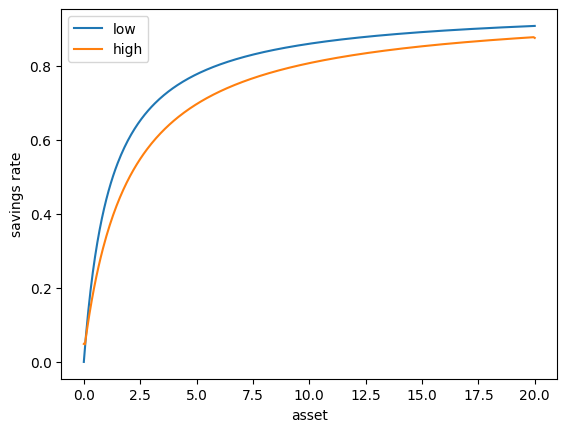

In [93]:
import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage

param = setPar() # parameters
decisions = solve_household(param) # HH problem
aplus = decisions[0]
c = decisions[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# saving rate for low h
plt.plot(a, aplus[:, 0]/(c[:, 0] + aplus[:, 0]), label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a, aplus[:, 1]/(c[:, 1] + aplus[:, 1]), label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()



問４. 問１のもとで主観的割引率を低下させる。(β=0.1)

In [103]:
# Solve No.4

# function to compile parameters into one thing "param"
def setPar(
    sigma = 1.5, # risk aversion
    beta = 0.1, # subject discount factor
    rho = 0.6, # labor productivity persistence
    sigma_eps = 0.6, # labor productivity std
    a_l = 0, # lower bound of asset grids
    a_u = 20, # upper bound of asset grids
    NA = 401, # number of grids of a
    NH = 2, # number of grids of h
    mu_h = -0.7, # mean of log h
    ):

    # # create a grid of asset holdings
    # a = np.linspace(a_l, a_u, NA)

    # making grids for ln h and solving for income transition probability using Tauchen's method
    pi, h = tauchen(NH, mu_h, rho, sigma_eps)
    h = np.exp(h)

    # create dictionary with parameters
    param = {}
    param['sigma'] = sigma
    param['beta'] = beta
    param['pi'] = pi
    param['h'] = h
    param['NA'] = NA
    param['NH'] = NH
    param['a_l'] = a_l
    param['a_u'] = a_u


    return param

In [104]:
def solve_household(param):
    # opening the box of param
    NA = param['NA']
    NH = param['NH']
    h = param['h']
    a_l = param['a_l']
    a_u = param['a_u']
    sigma = param['sigma']
    beta = param['beta']
    pi = param['pi']

    # create a grid of asset holdings
    a = np.linspace(a_l, a_u, NA)

    # Initialize some variables
    v = np.zeros((NA, NH))
    c = np.zeros((NA, NH))
    aplus = np.zeros((NA, NH))

    v_new = np.zeros((NA, NH))
    iaplus = np.full((NA, NH), -10000)
    util = np.full((NA, NA, NH), -10000.0)

    # calculate utility if the agent chooses asset a[iap] for (a[ia]), h[ih])
    for ia in range(NA):
        for ih in range(NH):
            for iap in range(NA):
                cons = w*h[ih] + (1.0 + r)*a[ia] - a[iap]
                if cons > 0: # count only if consumption is positive
                    util[iap, ia, ih] = cons**(1.0-sigma)/(1.0-sigma)

    # iterate on bellman's equation and get the decision rules and the value function
    tol = 1e-6
    test = 10.0
    reward = np.zeros((NA, NA, NH))

    while test > tol: # loop until value function converges
        for ia in range(NA):
            for ih in range(NH):
                reward[:, ia, ih] = util[:, ia, ih]
                for ihp in range(NH):
                    reward[:, ia, ih] += beta*pi[ih, ihp]*v[:, ihp]

                v_new[ia, ih] = np.max(reward[:, ia, ih])
                iaplus[ia, ih] = np.argmax(reward[:, ia, ih])

        test = np.max(abs(v_new - v))
        v = v_new

    # asset policy function
    aplus = a[iaplus]

    # consumption policy function
    for ia in range(NA):
        for ih in range(NH):
            c[ia, ih] = w*h[ih] + (1.0 + r)*a[ia] - aplus[ia, ih]

    return aplus, iaplus, c


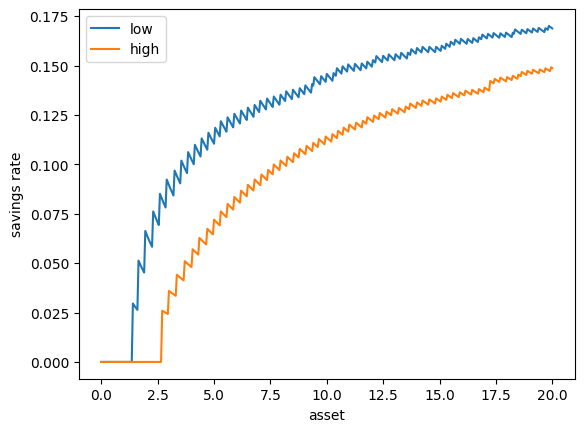

In [105]:
import matplotlib.pyplot as plt

# setting prices
r = 0.04 # interest rate
w = 1 # wage

param = setPar() # parameters
decisions = solve_household(param) # HH problem
aplus = decisions[0]
c = decisions[2]

# grids for figures
a_l = param['a_l']
a_u = param['a_u']
NA = param['NA']
a = np.linspace(a_l, a_u, NA)

# saving rate for low h
plt.plot(a, aplus[:, 0]/(c[:, 0] + aplus[:, 0]), label='low')
plt.xlabel("asset")
plt.ylabel("savings rate")

# saving rate for high h
plt.plot(a, aplus[:, 1]/(c[:, 1] + aplus[:, 1]), label='high')
plt.xlabel("asset")
plt.ylabel("savings rate")

plt.legend()

